#1. Install & Setup

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [4]:
!ls -a ~/.kaggle


.  ..  kaggle.json


In [5]:
import sys, torch, kaggle
print("Python :", sys.version)
print("PyTorch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
!kaggle --version


Python : 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch: 2.8.0+cu126 | CUDA: True
Kaggle API 1.7.4.5


#2 Download & Extract Dataset

In [6]:
# Download dataset kompetisi ke ./data
!mkdir -p ./data
!kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining -p ./data

 69% 144M/209M [00:00<00:00, 1.51GB/s]
100% 209M/209M [00:00<00:00, 864MB/s] 


In [7]:
import zipfile, os, glob

with zipfile.ZipFile('./data/penyisihan-hology-8-0-2025-data-mining.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

# Menampilkan isi folder data setelah ekstraksi
print("Isi ./data:", os.listdir("./data"))

# Hitung jumlah file JPG di train/images dan test/images
print("Train JPG :", len(glob.glob("./data/train/images/*.jpg")))
print("Train JSON:", len(glob.glob("./data/train/labels/*.json")))
print("Test JPG  :", len(glob.glob("./data/test/images/*.jpg")))


Isi ./data: ['test', 'train', 'sample_submission.csv', 'penyisihan-hology-8-0-2025-data-mining.zip']
Train JPG : 1900
Train JSON: 1900
Test JPG  : 500


# Crowd Counting dengan CSRNet (VGG16-BN, Dilated Backend)
Notebook ini merangkum alur lengkap dari **pemahaman masalah**, **EDA singkat**, **pembentukan peta kepadatan (density map)** dari anotasi **JSON titik kepala**, hingga **pelatihan model** dan **penyusunan submission**.  
Ringkas hasil: baseline CSRNet dilatih progresif (patch 384→640), dilanjutkan **fine-tune** terarah; evaluasi menggunakan **MAE** pada validasi internal. Notebook menampilkan contoh visual **gambar → titik → density → prediksi** agar alur mudah diikuti.


#**1. Persiapan**

In [8]:
import sys, os, random, json, glob, warnings, math
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import functional as TF
from torchvision import models
from scipy.spatial import distance_matrix

warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision("high")

print("Python :", sys.version)
print("PyTorch:", torch.__version__, "| CUDA:", torch.cuda.is_available())

# Repro
SEED = 2025
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

# Paths
DATA_DIR = "/content/data"
TRAIN_IMG_DIR = f"{DATA_DIR}/train/images"
TRAIN_LBL_DIR = f"{DATA_DIR}/train/labels"
TEST_IMG_DIR  = f"{DATA_DIR}/test/images"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Helper display
def imshow(img, title=None):
    plt.figure(figsize=(5,5))
    plt.imshow(img); plt.axis("off")
    if title: plt.title(title)
    plt.show()


Python : 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch: 2.8.0+cu126 | CUDA: True


#**2. Explanatory Data Analysis**

##Cek Dataset

In [9]:
# Hitung file dan tampilkan contoh struktur
train_imgs = sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, "*.jpg")))
train_json = sorted(glob.glob(os.path.join(TRAIN_LBL_DIR, "*.json")))
test_imgs  = sorted(glob.glob(os.path.join(TEST_IMG_DIR,  "*.jpg")))

print("Jumlah train images :", len(train_imgs))
print("Jumlah train labels :", len(train_json))
print("Jumlah test images  :", len(test_imgs))

# Ambil 10 file untuk statistik jumlah titik (kepala) per gambar
def safe_load_points(jp):
    try:
        with open(jp, "r") as f:
            ann = json.load(f)
        pts = []
        for pt in ann.get("points", []):
            if isinstance(pt, dict):
                x, y = float(pt.get("x", 0)), float(pt.get("y", 0))
            else:
                x, y = float(pt[0]), float(pt[1])
            if np.isfinite(x) and np.isfinite(y):
                pts.append([x, y])
        return np.asarray(pts, dtype=np.float32)
    except Exception as e:
        return np.zeros((0,2), dtype=np.float32)

samples = train_imgs[:50] if len(train_imgs)>=50 else train_imgs
counts  = []
for p in samples:
    jp = p.replace("/images/","/labels/").replace(".jpg",".json")
    counts.append(len(safe_load_points(jp)))
if counts:
    s = pd.Series(counts)
    print("Stat jumlah kepala (subset):")
    print(s.describe().to_string())


Jumlah train images : 1900
Jumlah train labels : 1900
Jumlah test images  : 500
Stat jumlah kepala (subset):
count      50.000000
mean      164.020000
std       337.213218
min         3.000000
25%        11.250000
50%        32.500000
75%       202.750000
max      2153.000000


## Cek labels (point)

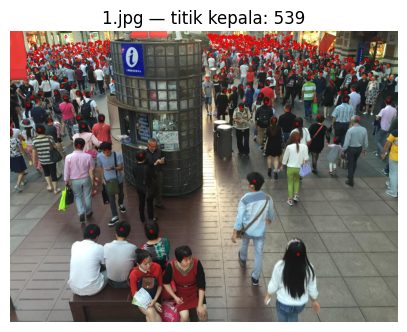

In [10]:
example_img = None
for p in train_imgs:
    jp = p.replace("/images/","/labels/").replace(".jpg",".json")
    if os.path.exists(jp) and len(safe_load_points(jp))>0:
        example_img = p
        break

if example_img is None and len(train_imgs)>0:
    example_img = train_imgs[0]

if example_img is not None:
    jp = example_img.replace("/images/","/labels/").replace(".jpg",".json")
    pts = safe_load_points(jp)
    im  = Image.open(example_img).convert("RGB")
    draw = ImageDraw.Draw(im)
    r = 3
    for (x,y) in pts:
        draw.ellipse((x-r, y-r, x+r, y+r), outline=(255,0,0), width=2)
    imshow(np.array(im), title=f"{os.path.basename(example_img)} — titik kepala: {len(pts)}")
else:
    print("Tidak ditemukan contoh bergambar.")


#**3. Konsep Density**

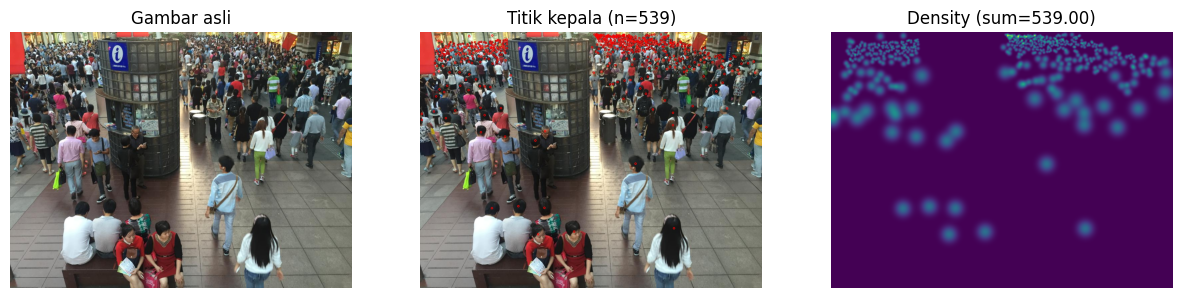

In [12]:
def load_points(json_path):
    with open(json_path, "r") as f:
        ann = json.load(f)
    pts = []
    for pt in ann.get("points", []):
        if isinstance(pt, dict):
            x, y = float(pt.get("x", 0)), float(pt.get("y", 0))
        else:
            x, y = float(pt[0]), float(pt[1])
        if np.isfinite(x) and np.isfinite(y):
            pts.append([x, y])
    return np.asarray(pts, dtype=np.float32)

def normdm(points, H, W, KNN_SIGMA_FACTOR=0.3, MIN_SIGMA=2, MAX_SIGMA=15):
    dm = np.zeros((H, W), np.float32)
    if points is None or len(points)==0: return dm
    pts = []
    for x, y in points:
        if 0<=x<W and 0<=y<H: pts.append([x,y])
    if not pts: return dm
    pts = np.asarray(pts, np.float32)
    if len(pts)>1:
        D = distance_matrix(pts, pts)
        np.fill_diagonal(D, np.inf)
        k = min(3, len(pts)-1)
        sigmas = []
        for i in range(len(pts)):
            if len(pts)>k:
                s = np.mean(np.sort(D[i])[:k]) * KNN_SIGMA_FACTOR
            else:
                s = 8.0
            sigmas.append(np.clip(s, MIN_SIGMA, MAX_SIGMA))
    else:
        sigmas = [8.0]
    for (x,y), s in zip(pts, sigmas):
        ksz = int(3*s)
        x1, x2 = max(0,int(x)-ksz), min(W,int(x)+ksz+1)
        y1, y2 = max(0,int(y)-ksz), min(H,int(y)+ksz+1)
        xx, yy = np.meshgrid(np.arange(x1,x2)-x, np.arange(y1,y2)-y)
        g = np.exp(-(xx**2 + yy**2)/(2*s*s))
        dm[y1:y2, x1:x2] += g
    s = dm.sum()
    if s>0: dm = dm*(len(pts)/s)  # jumlah density = jumlah titik
    return dm

# Visualisasi: gambar asli -> titik -> density
if example_img is not None:
    im0 = Image.open(example_img).convert("RGB")
    W, H = im0.size
    jp = example_img.replace("/images/","/labels/").replace(".jpg",".json")
    pts = load_points(jp)
    dm = normdm(pts, H, W)
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs[0].imshow(im0); axs[0].set_title("Gambar asli"); axs[0].axis("off")
    im_pts = im0.copy(); d = ImageDraw.Draw(im_pts)
    for (x,y) in pts: d.ellipse((x-3,y-3,x+3,y+3), outline=(255,0,0), width=2)
    axs[1].imshow(im_pts); axs[1].set_title(f"Titik kepala (n={len(pts)})"); axs[1].axis("off")
    axs[2].imshow(dm, cmap="viridis"); axs[2].set_title(f"Density (sum={dm.sum():.2f})"); axs[2].axis("off")
    plt.show()


#**4. Metode dan Arsitektur**

## Metode
Model yang digunakan mengikuti **CSRNet**: *frontend* VGG16-BN (tanpa pool5) untuk ekstraksi fitur skala-menengah, dilanjutkan *backend* dilated convolution untuk memperluas receptive field tanpa menurunkan resolusi lebih jauh. Keluaran model adalah **peta kepadatan** berukuran ~1/8 sisi input.

## Loss Function
Kombinasi: **MSE(density)** untuk kesetiaan bentuk peta, dan **L1(count)** pada jumlah total (sum pada peta). Opsi **SSIM** tersedia bernilai kecil untuk menjaga struktur halus pada peta.

## Alur Pelatihan
Pelatihan dilakukan bertahap dengan **patch progressive** (384→512→640), *freezing* awal pada frontend, lalu dilanjutkan **fine-tune** dengan LR lebih kecil dan evaluasi MAE berkala.


##Custom Dataset

In [13]:
MIN_SCALE, MAX_SCALE = 0.7, 1.3

class CrowdDS(Dataset):
    def __init__(self, img_paths, is_train=True, patch=384):
        self.imgs = img_paths
        self.is_train = is_train
        self.patch = patch
        self.norm = T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])

    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        p = self.imgs[idx]
        im = Image.open(p).convert("RGB")
        W, H = im.size
        jp = p.replace("/images/","/labels/").replace(".jpg",".json")
        pts = safe_load_points(jp)

        if self.is_train:
            s = random.uniform(MIN_SCALE, MAX_SCALE)
            nW, nH = int(W*s), int(H*s)
            im = im.resize((nW,nH), Image.BILINEAR)
            if len(pts)>0: pts = pts*s
            # crop + pad
            x1=y1=0
            if nW>=self.patch and nH>=self.patch:
                x1 = random.randint(0, nW-self.patch)
                y1 = random.randint(0, nH-self.patch)
            pad_w, pad_h = max(0,self.patch-nW), max(0,self.patch-nH)
            if pad_w or pad_h:
                im = TF.pad(im, (0,0,pad_w,pad_h))
                nW+=pad_w; nH+=pad_h
            x2,y2 = x1+self.patch, y1+self.patch
            im = im.crop((x1,y1,x2,y2))
            if len(pts)>0:
                m = (pts[:,0]>=x1)&(pts[:,0]<x2)&(pts[:,1]>=y1)&(pts[:,1]<y2)
                pts = pts[m]
                if len(pts)>0:
                    pts[:,0]-=x1; pts[:,1]-=y1
            # flip & color jitter ringan
            if random.random()>0.5:
                im = TF.hflip(im)
                if len(pts)>0: pts[:,0] = self.patch - pts[:,0]
            if random.random()>0.5:
                im = TF.adjust_brightness(im, random.uniform(0.9,1.1))
                im = TF.adjust_contrast(im,  random.uniform(0.9,1.1))
            dm = normdm(pts, self.patch, self.patch)
        else:
            MAXSIDE=1024
            s = min(MAXSIDE/max(W,H), 1.0)
            nW, nH = int(W*s), int(H*s)
            im = im.resize((nW,nH), Image.BILINEAR)
            if len(pts)>0: pts = pts*s
            pad_w, pad_h = MAXSIDE-nW, MAXSIDE-nH
            im = TF.pad(im, (0,0,pad_w,pad_h))
            dm = normdm(pts, MAXSIDE, MAXSIDE)

        x = self.norm(T.ToTensor()(im))
        y = torch.from_numpy(dm).unsqueeze(0)  # (1,H,W)
        cnt = float(len(pts))
        return x, y, cnt


#**5. Model CSRNet & Loss**

In [15]:
class CSRNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1 if pretrained else None).features
        self.frontend = nn.Sequential(*list(vgg.children())[:33])
        self.backend = nn.Sequential(
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(True),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(True),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(True),
            nn.Conv2d(512,256,3,padding=2,dilation=2), nn.ReLU(True),
            nn.Conv2d(256,128,3,padding=2,dilation=2), nn.ReLU(True),
            nn.Conv2d(128, 64,3,padding=2,dilation=2), nn.ReLU(True),
        )
        self.output_layer = nn.Conv2d(64,1,1)
        for m in self.backend.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None: nn.init.zeros_(m.bias)
        nn.init.normal_(self.output_layer.weight, std=0.01)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return F.relu(x, inplace=True)  # non-negatif

def ssim_loss(pred, tgt, C1=0.01**2, C2=0.03**2):
    mu_x = F.avg_pool2d(pred, 11, 1, 5); mu_y = F.avg_pool2d(tgt, 11, 1, 5)
    sigma_x = F.avg_pool2d(pred*pred,11,1,5) - mu_x*mu_x
    sigma_y = F.avg_pool2d(tgt*tgt, 11,1,5) - mu_y*mu_y
    sigma_xy= F.avg_pool2d(pred*tgt, 11,1,5) - mu_x*mu_y
    ssim_map = ((2*mu_x*mu_y + C1)*(2*sigma_xy + C2))/((mu_x*mu_x + mu_y*mu_y + C1)*(sigma_x + sigma_y + C2) + 1e-6)
    return (1 - ssim_map.mean())

W_DENSITY, W_COUNT, W_SSIM = 1.0, 0.5, 0.1

class ComboLoss(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pred_dm, tgt_dm):
        mse = F.mse_loss(pred_dm, tgt_dm)
        pred_cnt = pred_dm.sum(dim=(1,2,3))
        tgt_cnt  = tgt_dm.sum(dim=(1,2,3))
        cnt = F.l1_loss(pred_cnt, tgt_cnt)
        ssim = ssim_loss(pred_dm, tgt_dm) if W_SSIM>0 else pred_dm.new_tensor(0.0)
        total = W_DENSITY*mse + W_COUNT*cnt + W_SSIM*ssim
        return total, mse, cnt, ssim

def count_from_density(d):
    if d.dim()==4: return d.flatten(1).sum(1)
    return d.view(d.size(0), -1).sum(1)


##Validation Method

In [16]:
@torch.no_grad()
def evaluate_mae(model, val_list):
    model.eval()
    maes = []
    for img_path, gt_cnt in tqdm(val_list, desc="Valid"):
        im = Image.open(img_path).convert("RGB")
        W,H = im.size
        MAXSIDE=1024
        s = min(MAXSIDE/max(W,H), 1.0)
        nW,nH = int(W*s), int(H*s)
        im = im.resize((nW,nH), Image.BILINEAR)
        x = T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])(T.ToTensor()(im)).unsqueeze(0).to(DEVICE)
        with torch.cuda.amp.autocast():
            dm = model(x)
        pred_cnt = float(dm.sum().item())
        maes.append(abs(pred_cnt - gt_cnt))
    return float(np.mean(maes)) if maes else 0.0


##Split Data

In [17]:
VAL_RATIO = 0.10
all_imgs = sorted(glob.glob(f"{TRAIN_IMG_DIR}/*.jpg"))
random.shuffle(all_imgs)
n_val = int(len(all_imgs)*VAL_RATIO)
val_imgs = all_imgs[:n_val]
trn_imgs = all_imgs[n_val:]

val_list = []
for p in val_imgs:
    jp = p.replace("/images/","/labels/").replace(".jpg",".json")
    val_list.append((p, float(len(safe_load_points(jp)))))

print(f"Train: {len(trn_imgs)} | Val: {len(val_imgs)}")


Train: 1710 | Val: 190


#**6. Training Phase 1**

In [18]:
EPOCHS = 20
FREEZE_EPS = 5
BATCH_SIZE = 4
ACCUM = 2
LR = 1e-4
WD = 1e-5
PATCH_SIZES = [384, 512, 640]

model = CSRNet(pretrained=True).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=2, min_lr=1e-6)
scaler = torch.cuda.amp.GradScaler()
best_mae = 1e9
patience = 0

def train_epoch(model, loader, opt, scaler, epoch, freeze=False):
    model.train()
    for p in model.frontend.parameters(): p.requires_grad = not freeze
    losses=[]
    crit = ComboLoss()
    opt.zero_grad(set_to_none=True)
    step=0
    pbar = tqdm(loader, desc=f"Train e{epoch}")
    for xb, yb, _ in pbar:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast():
            pred = model(xb)
            if pred.shape[-2:] != yb.shape[-2:]:
                H_old,W_old = yb.shape[-2], yb.shape[-1]
                H_new,W_new = pred.shape[-2], pred.shape[-1]
                yb_rs = F.interpolate(yb, size=(H_new,W_new), mode="bilinear", align_corners=False)
                yb = yb_rs * ((H_old*W_old)/(H_new*W_new))
            loss, l_mse, l_cnt, l_ssim = crit(pred, yb)
        if not torch.isfinite(loss):
            opt.zero_grad(set_to_none=True)
            continue
        scaler.scale(loss).backward()
        step+=1
        if step % ACCUM == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update(); opt.zero_grad()
        losses.append(float(loss.item()))
        pbar.set_postfix({"loss": f"{loss.item():.3f}", "mse": f"{l_mse.item():.3f}", "cnt": f"{l_cnt.item():.3f}"})
    if step % ACCUM != 0:
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update(); opt.zero_grad()
    return float(np.mean(losses)) if losses else 0.0

for epoch in range(1, EPOCHS+1):
    if epoch<20:   patch = PATCH_SIZES[0]
    elif epoch<40: patch = PATCH_SIZES[1]
    else:          patch = PATCH_SIZES[2]

    ds = CrowdDS(trn_imgs, is_train=True, patch=patch)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

    freeze = (epoch<=FREEZE_EPS)
    trn_loss = train_epoch(model, dl, opt, scaler, epoch, freeze=freeze)

    if epoch % 5 == 0:
        mae = evaluate_mae(model, val_list)
        print(f"Epoch {epoch}: train_loss={trn_loss:.3f} | val_MAE={mae:.2f}")
        sch.step(mae)
        if np.isfinite(mae) and mae<best_mae:
            best_mae = mae
            torch.save(model.state_dict(), "best_csrnet.pth")
            print(" -> New best saved")
            patience=0
        else:
            patience+=1
        if patience>=8:
            print("Early stopping"); break
    else:
        print(f"Epoch {epoch}: train_loss={trn_loss:.3f}")

if os.path.exists("best_csrnet.pth"):
    model.load_state_dict(torch.load("best_csrnet.pth", map_location=DEVICE))
    print(f"Loaded best model (val MAE={best_mae:.2f})")


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:07<00:00, 77.8MB/s]
Train e1: 100%|██████████| 427/427 [01:07<00:00,  6.34it/s, loss=3.061, mse=0.000, cnt=5.942]


Epoch 1: train_loss=16.442


Train e2: 100%|██████████| 427/427 [00:57<00:00,  7.46it/s, loss=1.117, mse=0.000, cnt=2.052]


Epoch 2: train_loss=12.220


Train e3: 100%|██████████| 427/427 [00:59<00:00,  7.16it/s, loss=69.658, mse=0.029, cnt=139.074]


Epoch 3: train_loss=10.173


Train e4: 100%|██████████| 427/427 [00:50<00:00,  8.51it/s, loss=13.788, mse=0.011, cnt=27.378]


Epoch 4: train_loss=9.303


Valid: 100%|██████████| 190/190 [00:20<00:00,  9.19it/s]


Epoch 5: train_loss=8.618 | val_MAE=38.96
 -> New best saved


Train e6: 100%|██████████| 427/427 [01:13<00:00,  5.80it/s, loss=2.004, mse=0.000, cnt=3.832]


Epoch 6: train_loss=10.496


Train e7: 100%|██████████| 427/427 [00:56<00:00,  7.50it/s, loss=2.127, mse=0.000, cnt=4.079]


Epoch 7: train_loss=9.357


Train e8: 100%|██████████| 427/427 [00:57<00:00,  7.42it/s, loss=3.417, mse=0.000, cnt=6.655]


Epoch 8: train_loss=10.187


Train e9: 100%|██████████| 427/427 [00:57<00:00,  7.45it/s, loss=1.036, mse=0.000, cnt=1.894]


Epoch 9: train_loss=7.936


Valid: 100%|██████████| 190/190 [00:07<00:00, 25.25it/s]


Epoch 10: train_loss=8.235 | val_MAE=49.99


Train e11: 100%|██████████| 427/427 [00:57<00:00,  7.36it/s, loss=1.218, mse=0.000, cnt=2.258]


Epoch 11: train_loss=8.170


Train e12: 100%|██████████| 427/427 [00:58<00:00,  7.36it/s, loss=25.134, mse=0.004, cnt=50.089]


Epoch 12: train_loss=7.353


Train e13: 100%|██████████| 427/427 [00:58<00:00,  7.35it/s, loss=1.813, mse=0.006, cnt=3.437]


Epoch 13: train_loss=7.633


Train e14: 100%|██████████| 427/427 [00:57<00:00,  7.47it/s, loss=8.135, mse=0.002, cnt=16.091]


Epoch 14: train_loss=6.583


Valid: 100%|██████████| 190/190 [00:07<00:00, 25.40it/s]


Epoch 15: train_loss=7.583 | val_MAE=37.15
 -> New best saved


Train e16: 100%|██████████| 427/427 [00:56<00:00,  7.51it/s, loss=0.606, mse=0.000, cnt=1.039]


Epoch 16: train_loss=7.328


Train e17: 100%|██████████| 427/427 [00:57<00:00,  7.48it/s, loss=3.710, mse=0.032, cnt=7.188]


Epoch 17: train_loss=6.857


Train e18: 100%|██████████| 427/427 [00:57<00:00,  7.36it/s, loss=5.387, mse=0.006, cnt=10.592]


Epoch 18: train_loss=6.086


Train e19: 100%|██████████| 427/427 [00:57<00:00,  7.39it/s, loss=25.755, mse=0.016, cnt=51.317]


Epoch 19: train_loss=6.259


Valid: 100%|██████████| 190/190 [00:07<00:00, 26.12it/s]


Epoch 20: train_loss=9.196 | val_MAE=45.31
Loaded best model (val MAE=37.15)


##Visualisasi Fase 1

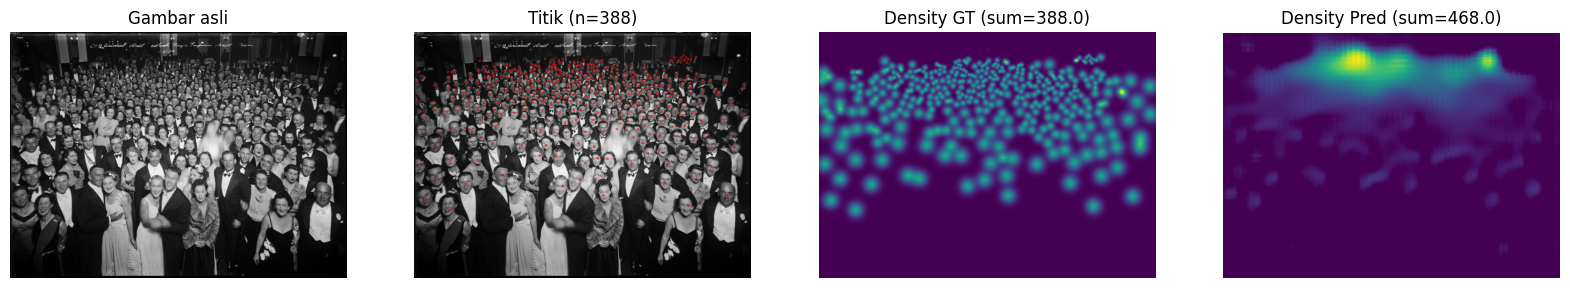

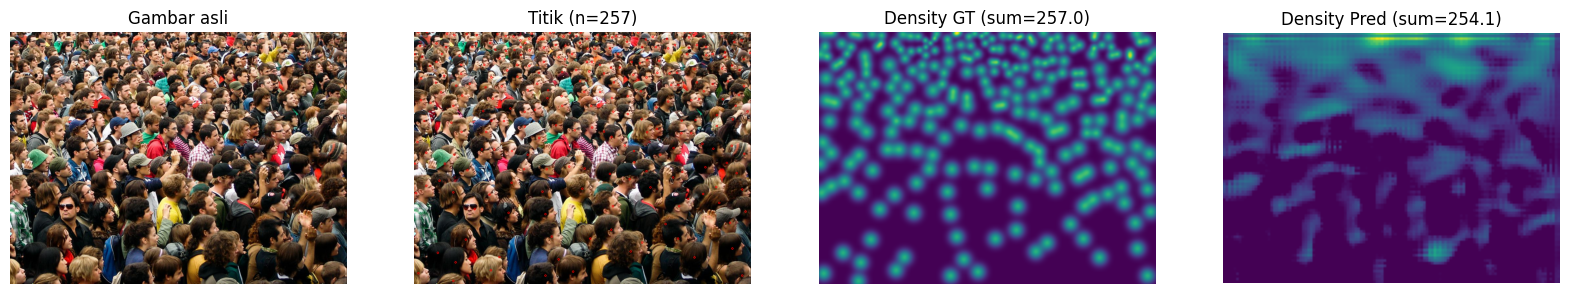

In [19]:
@torch.no_grad()
def visualize_pipeline(img_path, model):
    im = Image.open(img_path).convert("RGB")
    W,H = im.size
    jp = img_path.replace("/images/","/labels/").replace(".jpg",".json")
    pts = safe_load_points(jp)
    dm_gt = normdm(pts, H, W)

    # Prediksi (resize ke sisi maks 1024)
    MAXSIDE=1024
    s = min(MAXSIDE/max(W,H), 1.0)
    nW,nH = int(W*s), int(H*s)
    im_r = im.resize((nW,nH), Image.BILINEAR)
    x = T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])(T.ToTensor()(im_r)).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.cuda.amp.autocast():
        dm_pred = model(x)[0,0].detach().cpu().numpy()
    pred_cnt = float(dm_pred.sum())

    # Visual
    fig, axs = plt.subplots(1,4, figsize=(20,5))
    axs[0].imshow(im); axs[0].set_title("Gambar asli"); axs[0].axis("off")
    im_pts = im.copy(); d = ImageDraw.Draw(im_pts)
    for (x0,y0) in pts: d.ellipse((x0-3,y0-3,x0+3,y0+3), outline=(255,0,0), width=2)
    axs[1].imshow(im_pts); axs[1].set_title(f"Titik (n={len(pts)})"); axs[1].axis("off")
    axs[2].imshow(dm_gt, cmap="viridis"); axs[2].set_title(f"Density GT (sum={dm_gt.sum():.1f})"); axs[2].axis("off")
    axs[3].imshow(dm_pred, cmap="viridis"); axs[3].set_title(f"Density Pred (sum={pred_cnt:.1f})"); axs[3].axis("off")
    plt.show()

# 2 contoh dari val
for p,_ in val_list[:2]:
    visualize_pipeline(p, model)


#**7. Training Fase 2**

In [27]:
# === FINETUNE SETUP ===
import torch, os, numpy as np

# adjust loss weights
W_SSIM  = 0.0
W_COUNT = 0.7

# perketat TTA
def _eval_scales(): return [0.95, 1.0, 1.05]
def _test_scales(): return [0.9, 1.0, 1.1]


evaluate_scales = _eval_scales
submission_scales = _test_scales

# model & optimizer
model = CSRNet(pretrained=False).to(DEVICE)
if os.path.exists("best_csrnet.pth"):
    model.load_state_dict(torch.load("best_csrnet.pth", map_location=DEVICE))
    print("Loaded best checkpoint for finetune.")

# optimizer lebih kecil LR
opt = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=WD)

# scheduler lebih responsif
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, factor=0.5, patience=1, min_lr=1e-6
)

scaler = torch.cuda.amp.GradScaler()

# rebuild train/val split & dataloaders
all_imgs = sorted(glob.glob(f"{TRAIN_IMG_DIR}/*.jpg"))
np.random.seed(SEED); np.random.shuffle(all_imgs)
n_val = int(len(all_imgs)*VAL_RATIO)
val_imgs = all_imgs[:n_val]
trn_imgs = all_imgs[n_val:]

val_list=[]
for p in val_imgs:
    pts = load_points(p.replace("/images/","/labels/").replace(".jpg",".json"))
    val_list.append((p, float(len(pts))))


Loaded best checkpoint for finetune.


##Loop fase 2

In [ ]:
best_mae = 1e9
patience = 0
EPOCHS_FT = 20
PATCH_SIZES_FT = [512, 640]

for epoch in range(1, EPOCHS_FT+1):
    patch = PATCH_SIZES_FT[0] if epoch <= 8 else PATCH_SIZES_FT[1]
    ds = CrowdDS(trn_imgs, is_train=True, patch=patch)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

    # train (tanpa freeze)
    trn_loss = train_epoch(model, dl, opt, scaler, epoch, freeze=False)

    # eval tiap 3 epoch
    if epoch % 3 == 0:
        def evaluate_mae_tight(model, val_list):
            model.eval()
            maes=[]
            for img_path, gt_cnt in val_list:
                im = Image.open(img_path).convert("RGB")
                W,H = im.size
                MAXSIDE = 1024
                s = min(MAXSIDE/max(W,H), 1.0)
                nW,nH = int(W*s), int(H*s)
                im = im.resize((nW,nH), Image.BILINEAR)
                preds=[]
                for ss in evaluate_scales():
                    tw, th = int(nW*ss), int(nH*ss)
                    im_s = im.resize((tw,th), Image.BILINEAR)
                    x = T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])(T.ToTensor()(im_s)).unsqueeze(0).to(DEVICE)
                    with torch.cuda.amp.autocast():
                        dm = model(x)
                    preds.append(float(dm.sum().item()))
                pred_cnt = float(np.mean(preds))
                maes.append(abs(pred_cnt - gt_cnt))
            return float(np.mean(maes)) if maes else 0.0

        mae = evaluate_mae_tight(model, val_list)
        print(f"[FT] Epoch {epoch}: train_loss={trn_loss:.3f}  val_MAE={mae:.2f}")

        sch.step(mae)
        if np.isfinite(mae) and mae < best_mae:
            best_mae = mae
            torch.save(model.state_dict(), "best_csrnet_ft.pth")
            print("  -> New best (FT) saved.")
            patience = 0
        else:
            patience += 1
            if patience >= 6:
                print("Early stop (FT).")
                break
    else:
        print(f"[FT] Epoch {epoch}: train_loss={trn_loss:.3f}")

print("Finetune done. Best MAE:", best_mae)


#**8. Analisis Error**

In [ ]:
@torch.no_grad()
def error_gallery(model, pairs, k=8):
    model.eval()
    rows = []
    for img_path, gt_cnt in pairs[:k]:
        im = Image.open(img_path).convert("RGB")
        W,H = im.size
        MAXSIDE=1024
        s = min(MAXSIDE/max(W,H), 1.0)
        nW,nH = int(W*s), int(H*s)
        im_r = im.resize((nW,nH), Image.BILINEAR)
        x = T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])(T.ToTensor()(im_r)).unsqueeze(0).to(DEVICE)
        dm = model(x)
        pred = float(dm.sum().item())
        rows.append({"image": os.path.basename(img_path), "gt": float(gt_cnt), "pred": pred, "abs_err": abs(pred-gt_cnt)})
    df = pd.DataFrame(rows).sort_values("abs_err", ascending=False)
    display(df.head(min(k, len(df))))

# Menampilkan 8 kasus terburuk
error_gallery(ft if os.path.exists("best_csrnet_ft.pth") else model, val_list, k=8)
